In [1]:
import os.path as op

from wordcloud import WordCloud
import plotly.express as px
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# import utils 
from utils import _cogat_vocabulary, _generate_counts

In [2]:
sns.set_theme(style="white")
FONTSIZE = 12
NEUROSCOUT_OWNER_ID = 5761
DPI = 300

CMAP = mpl.colormaps.get_cmap("tab20")

In [3]:
data_dir = "../data"
pubget_dir = op.join(data_dir, "pubget_data")
query_extensive = "query_875641cf4cbc22f32027447cd62fca27"
query_neurovault = "query_a444c1d1cc79f746a519d97ce9672089"
fig_dir = "./neurovault_data"
neurovault_dir = op.join(data_dir, "nv-data", "february_2024")

In [4]:
def _n_colls(df):
    return df.collection_id.unique().size

def _n_cogats(df):
    return df.cognitive_paradigm_cogatlas_id.unique().size


def _n_images(df):
    return df.image_id.unique().size

def _check_string(s):
    return all(c.isdigit() for c in s)

def _convert_collection_id(collection_id, collections_df):
    if str(collection_id).isalpha():
        matches = collections_df[collections_df.private_token == collection_id]
        return matches.id.values[0] if matches.size > 0 else None
    else:
        return int(collection_id) if _check_string(str(collection_id)) else None
    
def _plot_hist(series, x_label):
    df = pd.DataFrame(series)
    df.index = df.index.astype(str)
    df = df.rename(columns={df.columns[0]: x_label}) 

    fig = px.bar(
        df,
        x=x_label,
        orientation='h',
    )
    
    return fig

def _plot_pie(data, values, names, text_inside=False, reversed=False):
    height, width = 1.5, 1.5

    n_colors = len(data[names].unique())
    cmap = px.colors.qualitative.G10[:n_colors][::-1] if reversed else px.colors.qualitative.G10[:n_colors]
    fig = px.pie(
        data, 
        values=values, 
        names=names, 
        color_discrete_sequence=cmap,
    )
    fig.update_layout(
        height=height*DPI,
        width=width*DPI,
    )
    if text_inside:
        fig.update_traces(textposition='inside', textinfo='percent+label')
    return fig

def _join_pubget_queries(pubget_dir, queries):
    assert len(queries) > 0

    coordinates = pd.read_csv(
        op.join(pubget_dir, queries[0], "subset_allArticles_extractedData", "coordinates.csv")
    )
    metadata = pd.read_csv(
        op.join(pubget_dir, queries[0], "subset_allArticles_extractedData", "metadata.csv")
    )
    neurovault = pd.read_csv(
        op.join(pubget_dir, queries[0], "subset_allArticles_extractedData", "neurovault_collections.csv")
    )
    
    if len(queries) == 1:
        return coordinates, metadata, neurovault

    for query in queries[1:]:
        coordinates = pd.merge(
            coordinates,
            pd.read_csv(
                op.join(pubget_dir, query, "subset_allArticles_extractedData", "coordinates.csv")
            ),
            how="outer",
        )
        metadata = pd.merge(
            metadata,
            pd.read_csv(
                op.join(pubget_dir, query, "subset_allArticles_extractedData", "metadata.csv")
            ),
            how="outer",
        )
        neurovault = pd.merge(
            neurovault,
            pd.read_csv(
                op.join(pubget_dir, query, "subset_allArticles_extractedData", "neurovault_collections.csv")
            ),
            how="outer",
        )

    return coordinates, metadata, neurovault

In [5]:
collections = pd.read_csv(op.join(neurovault_dir, "statmaps_collection.csv"))
basecollectionitem = pd.read_csv(op.join(neurovault_dir, "statmaps_basecollectionitem.csv"))
statisticmap = pd.read_csv(op.join(neurovault_dir, "statmaps_statisticmap.csv"))
cogat_task = pd.read_csv(op.join(neurovault_dir, "statmaps_cognitiveatlastask.csv"))
image = pd.read_csv(op.join(neurovault_dir, "statmaps_image.csv"))
image_merged = pd.merge(
    image, basecollectionitem, left_on="basecollectionitem_ptr_id", right_on="id"
)
statisticmap_merged = pd.merge(
    statisticmap, image_merged, left_on="image_ptr_id", right_on="basecollectionitem_ptr_id"
)
collections = pd.merge(
    collections, 
    basecollectionitem.groupby('collection_id').size().reset_index().rename(columns={0: 'n_images'}),
    left_on='id',
    right_on='collection_id',
)
collections = collections[collections.n_images > 0]
collections = collections[collections.owner_id != NEUROSCOUT_OWNER_ID]

collections_pmid_df = pd.read_csv(op.join(data_dir, "nv_collections.csv"))
collections_pmid_df["collection_id"] = collections_pmid_df["collection_id"].astype("int64")
statisticmap_colelctions = pd.read_csv(op.join(data_dir, "nv_collections_images.csv"))
pmid_text = pd.read_csv(op.join(data_dir, "pmid_text.csv"))


/var/folders/m9/_ygtgkg17990695673wz4l78j5bsz9/T/ipykernel_6812/2599462920.py:1: DtypeWarning: Columns (65) have mixed types. Specify dtype option on import or set low_memory=False.
  collections = pd.read_csv(op.join(neurovault_dir, "statmaps_collection.csv"))
/var/folders/m9/_ygtgkg17990695673wz4l78j5bsz9/T/ipykernel_6812/2599462920.py:3: DtypeWarning: Columns (4,5,7,15,17) have mixed types. Specify dtype option on import or set low_memory=False.
  statisticmap = pd.read_csv(op.join(neurovault_dir, "statmaps_statisticmap.csv"))
/var/folders/m9/_ygtgkg17990695673wz4l78j5bsz9/T/ipykernel_6812/2599462920.py:5: DtypeWarning: Columns (2,3,6,7,16,18,19,22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  image = pd.read_csv(op.join(neurovault_dir, "statmaps_image.csv"))


# NeuroVault data

### Collections with coordinates

In [6]:
coordinates, metadata, neurovault = _join_pubget_queries(pubget_dir, [query_neurovault])

In [7]:
coordinate_counts = coordinates.groupby('pmcid').count().reset_index()[['pmcid', 'table_id']].rename(columns={'table_id': 'coordinate_count'})
nv_coordinate_counts = pd.merge(neurovault, coordinate_counts, how='outer', on='pmcid')
nv_coordinate_counts = pd.merge(nv_coordinate_counts, metadata[['pmcid', 'publication_year']], how='left')
nv_coordinate_counts['has_only_coordinates'] = (nv_coordinate_counts.coordinate_count.isna() == False) & (nv_coordinate_counts.collection_id.isna())
nv_coordinate_counts['has_only_collection'] = (nv_coordinate_counts.collection_id.isna() == False) & ((nv_coordinate_counts.coordinate_count.isna()))
nv_coordinate_counts['has_both'] = (nv_coordinate_counts.collection_id.isna() == False) & ((nv_coordinate_counts.coordinate_count.isna() == False))
nv_coordinate_counts = nv_coordinate_counts[nv_coordinate_counts["publication_year"] != 2024]

,pmcid,collection_id,coordinate_count,publication_year,has_only_coordinates,has_only_collection,has_both
0,6879500,UTZRKARR,NaN,2019,False,True,False
1,4543077,550,NaN,2015,False,True,False
2,10068819,3731,NaN,2023,False,True,False
3,8152844,262,7.0,2021,False,False,True
4,4738700,WTMVBEZP,NaN,2016,False,True,False
...,...,...,...,...,...,...,...
717,10458690,NaN,14.0,2023,True,False,False
718,10577216,NaN,5.0,2023,True,False,False
719,10636420,NaN,28.0,2023,True,False,False
720,10641579,NaN,16.0,2023,True,False,False


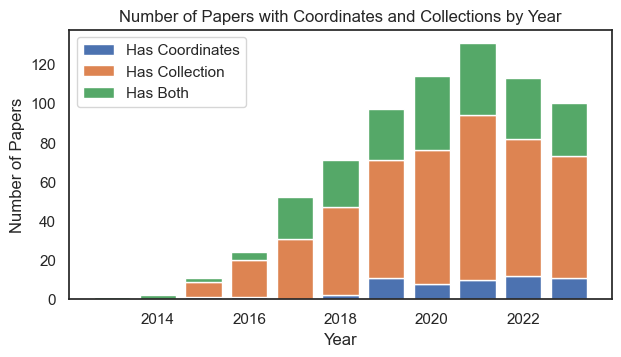

In [8]:
df_counts = nv_coordinate_counts.groupby('publication_year').size().reset_index(name='counts')

# Separate the counts into two columns based on whether the row has a coordinate or a collection
df_counts['has_only_coordinates'] = nv_coordinate_counts.groupby('publication_year')['has_only_coordinates'].sum().values
df_counts['has_only_collection'] = nv_coordinate_counts.groupby('publication_year')['has_only_collection'].sum().values
df_counts['has_both'] = nv_coordinate_counts.groupby('publication_year')['has_both'].sum().values

# Set the figure size and create a bar plot
height = 3.5
width = (df_counts.shape[0] + 3)/2
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(width, height)

plt.bar(df_counts['publication_year'], df_counts['has_only_coordinates'], label='Has Coordinates')
plt.bar(df_counts['publication_year'], df_counts['has_only_collection'], bottom=df_counts['has_only_coordinates'], label='Has Collection')
plt.bar(df_counts['publication_year'], df_counts['has_both'], bottom=df_counts['has_only_collection']+df_counts['has_only_coordinates'], label='Has Both')

# Add labels and titles
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.title('Number of Papers with Coordinates and Collections by Year')
plt.legend()
fig.savefig(op.join(fig_dir, "00_coords_and_coll_by_year.png"), bbox_inches='tight', dpi=DPI)
plt.show()

### Collections per year

In [9]:
collections_by_year = collections[["id", "add_date", 'DOI']].rename(columns={"add_date": "year"})
years = [date.split("-")[0] for date in collections_by_year["year"]]
collections_by_year["year"] = years
# Drop 2024 collecitons
collections_by_year = collections_by_year[collections_by_year["year"] != "2024"]
collections_by_year_df = collections_by_year.groupby("year").size()
collections_by_year_doi_df = collections_by_year.dropna(subset=["DOI"]).groupby("year").size()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


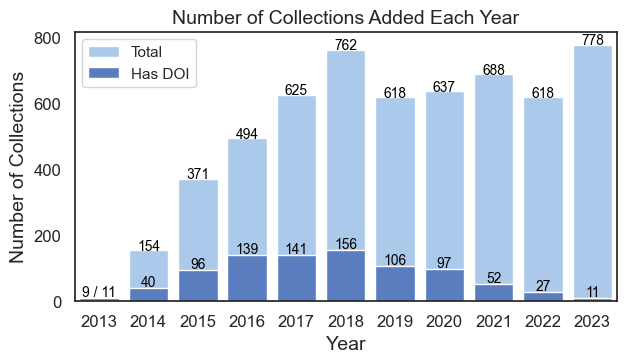

In [10]:
height = 3.5
width = (collections_by_year_df.shape[0] + 3)/2
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(width, height)

sns.set_color_codes("pastel")
sns.barplot(data=collections_by_year_df, label="Total", color="b", ax=ax)
for i, v in enumerate(collections_by_year_df.values):
    if i != 0:
        ax.text(i, v + 0.5, str(v), color='black', ha='center', fontsize=FONTSIZE-2)
    else:
        pre = v # Save the first value for later

sns.set_color_codes("muted")
sns.barplot(data=collections_by_year_doi_df, label="Has DOI", color="b", ax=ax)
for i, v in enumerate(collections_by_year_doi_df.values):
    label = f"{str(v)} / {pre}" if i == 0 else str(v)
    ax.text(i, v + 5, label, color='black', ha='center', fontsize=FONTSIZE-2)

ax.legend(ncol=1, loc="upper left", frameon=True)
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
ax.set_xlabel("Year", fontsize=FONTSIZE+2)
ax.set_ylabel("Number of Collections", fontsize=FONTSIZE+2)
ax.set_title("Number of Collections Added Each Year", fontsize=FONTSIZE+2)
fig.savefig(op.join(fig_dir, "01_collections_by_year.png"), bbox_inches='tight', dpi=DPI)
plt.show()

### Proporion of private collections

In [11]:
collection_by_private = collections.groupby("private").size()
collection_by_private = pd.DataFrame(collection_by_private)
collection_by_private = collection_by_private.rename(columns={collection_by_private.columns[0]: "count"})
collection_by_private = collection_by_private.reset_index()
collection_by_private["private"] = collection_by_private["private"].replace({"f": "Public", "t": "Private"})

In [12]:
fig = _plot_pie(collection_by_private, 'count', 'private', text_inside=True)
fig.write_html(op.join(fig_dir, "02_collections_private.html"), full_html=True, include_plotlyjs=True)
fig.write_image(op.join(fig_dir, "02_collections_private.png"), scale=6)
fig.show()

## Images per year

In [13]:
statisticmap_merged_red = statisticmap_merged[
    statisticmap_merged.collection_id.isin(collections.id)
]
img_years = [date.split("-")[0] for date in statisticmap_merged_red["add_date"]]
statisticmap_merged_red["year"] = img_years

images_by_year = statisticmap_merged_red[
    ["image_ptr_id", "year", "cognitive_paradigm_cogatlas_id", "cognitive_contrast_cogatlas_id"]
]
images_by_year = images_by_year[images_by_year["year"] != "2024"]
images_by_year_df = images_by_year.groupby("year").size()
images_by_year_task_df = (
    images_by_year.dropna(subset=["cognitive_paradigm_cogatlas_id"]).groupby("year").size()
)
images_by_year_contrast_df = images_by_year.dropna(subset=["cognitive_contrast_cogatlas_id"])[images_by_year["cognitive_contrast_cogatlas_id"] != "Other"].groupby("year").size()

/var/folders/m9/_ygtgkg17990695673wz4l78j5bsz9/T/ipykernel_6812/4172881172.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/m9/_ygtgkg17990695673wz4l78j5bsz9/T/ipykernel_6812/4172881172.py:15: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


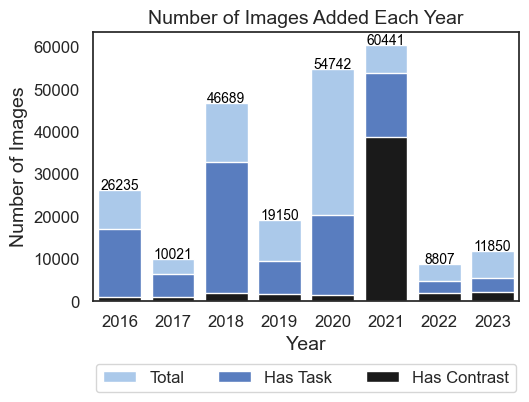

In [14]:
height = 3.5
width = (images_by_year_df.shape[0] + 3)/2
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(width, height)

sns.set_color_codes("pastel")
sns.barplot(data=images_by_year_df, label="Total", color="b", ax=ax)
for i, v in enumerate(images_by_year_df.values):
    ax.text(i, v + 100, str(v), color='black', ha='center', fontsize=FONTSIZE-2)

sns.set_color_codes("muted")
sns.barplot(data=images_by_year_task_df, label="Has Task", color="b", ax=ax)
sns.barplot(data=images_by_year_contrast_df, label="Has Contrast", color="k", ax=ax)

ax.legend(ncol=3, loc="upper center", bbox_to_anchor=(0.5, -0.2), frameon=True, fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
ax.set_xlabel("Year", fontsize=FONTSIZE+2)
ax.set_ylabel("Number of Images", fontsize=FONTSIZE+2)
ax.set_title("Number of Images Added Each Year", fontsize=FONTSIZE+2)
fig.savefig(op.join(fig_dir, "03_images_by_year.png"), bbox_inches='tight', dpi=DPI)
plt.show()

### Images thresholded

In [15]:
images_thresholded = statisticmap_merged_red.groupby("is_thresholded").size()
images_thresholded = pd.DataFrame(images_thresholded)
images_thresholded = images_thresholded.rename(columns={images_thresholded.columns[0]: "count"})
images_thresholded = images_thresholded.reset_index()
images_thresholded["is_thresholded"] = images_thresholded["is_thresholded"].replace({"f": "Unthresholded", "t": "Thresholded"})

In [16]:
fig = _plot_pie(images_thresholded, 'count', 'is_thresholded', text_inside=True)
fig.write_html(op.join(fig_dir, "04_images_thresholded.html"), full_html=True, include_plotlyjs=True)
fig.write_image(op.join(fig_dir, "04_images_thresholded.png"), scale=6)
fig.show()

### Images in MNI

In [17]:
images_mni = statisticmap_merged_red.groupby("not_mni").size()
images_mni = pd.DataFrame(images_mni)
images_mni = images_mni.rename(columns={images_mni.columns[0]: "count"})
images_mni = images_mni.reset_index()
images_mni["not_mni"] = images_mni["not_mni"].replace({"f": "MNI", "t": "Not MNI"})

In [18]:
fig = _plot_pie(images_mni, 'count', 'not_mni')
fig.write_html(op.join(fig_dir, "05_images_mni.html"), full_html=True, include_plotlyjs=True)
fig.write_image(op.join(fig_dir, "05_images_mni.png"), scale=6)
fig.show()

### Image modality

In [19]:
image_by_modality = statisticmap_merged_red.groupby("modality").size()
image_by_modality = pd.DataFrame(image_by_modality)
image_by_modality = image_by_modality.rename(columns={image_by_modality.columns[0]: "count"})
image_by_modality = image_by_modality.reset_index()

In [20]:
fig = _plot_pie(image_by_modality, 'count', 'modality')
fig.write_html(op.join(fig_dir, "06_images_by_modality.html"), full_html=True, include_plotlyjs=True)
fig.write_image(op.join(fig_dir, "06_images_by_modality.png"), scale=6)
fig.show()

### Map type

In [21]:
statisticmap_fmri = statisticmap_merged_red[statisticmap_merged_red.modality == "fMRI-BOLD"]
image_by_type = statisticmap_fmri.groupby("map_type").size()
image_by_type = pd.DataFrame(image_by_type)
image_by_type = image_by_type.rename(columns={image_by_type.columns[0]: "count"})
image_by_type = image_by_type.reset_index()

In [22]:
fig = _plot_pie(image_by_type, 'count', 'map_type')
fig.write_html(op.join(fig_dir, "07_images_by_maptype.html"), full_html=True, include_plotlyjs=True)
fig.write_image(op.join(fig_dir, "07_images_by_maptype.png"), scale=6)
fig.show()

### Analysis level

In [23]:
image_by_analysis = statisticmap_fmri.groupby("analysis_level").size()
image_by_analysis = pd.DataFrame(image_by_analysis)
image_by_analysis = image_by_analysis.rename(columns={image_by_analysis.columns[0]: "count"})
image_by_analysis = image_by_analysis.reset_index()

In [24]:
image_by_analysis

,analysis_level,count
0,G,18047
1,M,1911
2,Other,1563
3,S,158604


In [25]:
fig = _plot_pie(image_by_analysis, 'count', 'analysis_level')
fig.write_html(op.join(fig_dir, "08_images_by_analysis.html"), full_html=True, include_plotlyjs=True)
fig.write_image(op.join(fig_dir, "08_images_by_analysis.png"), scale=6)
fig.show()

### Cognitive atlas task representation

In [26]:
statisticmap_fmri_cogat = statisticmap_fmri.dropna(subset=["cognitive_paradigm_cogatlas_id"])[["cognitive_paradigm_cogatlas_id", "image_ptr_id"]] 
statisticmap_fmri_cogat = pd.merge(statisticmap_fmri_cogat, cogat_task, how="left", left_on="cognitive_paradigm_cogatlas_id", right_on="cog_atlas_id")

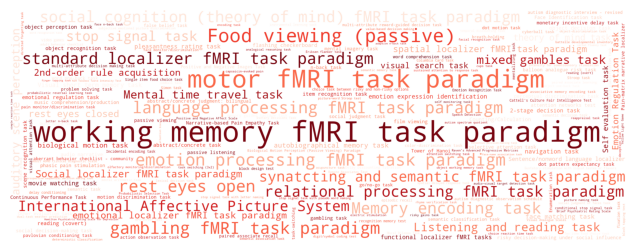

In [27]:
width, height = 8, 3
fig, ax = plt.subplots(figsize=(width, height))

frequencies_dict = dict(statisticmap_fmri_cogat.groupby("name").size())

wc = WordCloud(
    width=width * DPI,
    height=height * DPI,
    background_color="white",
    random_state=0,
    colormap="Reds",
)
wc.generate_from_frequencies(frequencies=frequencies_dict)
ax.imshow(wc)

ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
for spine in ax.spines.values():
    spine.set_visible(False)


fig.savefig(op.join(fig_dir, "09_cogat_count.png"), bbox_inches="tight", dpi=DPI)
plt.show()

### Image by modalities and map type

In [28]:
# Initialize the list for sunburst plot
labels = ["NeuroVault"]
parents = [""]
values = [statisticmap_merged_red.shape[0]]
statisticmap_with_filled = statisticmap_merged_red.copy()
statisticmap_with_filled["modality"] = statisticmap_with_filled["modality"].fillna("Missing")
statisticmap_with_filled["map_type"] = statisticmap_with_filled["map_type"].replace({"Other": "Others"})
modalities = statisticmap_with_filled.modality.unique()
for modality in modalities:
    labels.append(modality)
    parents.append("NeuroVault")
    values.append(statisticmap_with_filled[statisticmap_with_filled.modality == modality].shape[0])
    if modality == "fMRI-BOLD":
        map_types = statisticmap_with_filled.map_type.unique()
        for map_type in map_types:
            labels.append(map_type)
            parents.append(modality)
            values.append(statisticmap_with_filled.query(f'modality == "fMRI-BOLD" & map_type == "{map_type}"').shape[0])

In [29]:
import plotly.graph_objects as go

fig = go.Figure(go.Sunburst(
    labels=labels,
    parents=parents,
    values=values,
    branchvalues="total",
))
fig.update_layout(margin = dict(t=0, l=0, r=0, b=0))
fig.write_html(op.join(fig_dir, "10_images_sunburst.html"), full_html=True, include_plotlyjs=True)
fig.show()

# Collections with linked to PubMed

In [30]:
coll_per_source = collections_pmid_df.groupby("source").size().sort_values(ascending=False)
coll_per_source = pd.DataFrame(coll_per_source)
coll_per_source = coll_per_source.rename(columns={coll_per_source.columns[0]: "count"})
coll_per_source = coll_per_source.reset_index()
new_row = pd.DataFrame({"source": ["PMIDs Missing"], "count": [len(collections) - len(collections_pmid_df)]})
coll_per_source = pd.merge(coll_per_source, new_row, how="outer")

In [31]:
mapping = {
    'neurovault': 'DOI in NV', 
    'pubmed': 'Title matching PubMed', 
    'pubget': 'Pubget search',
    "metadata": "DOI in description",
}
coll_per_source["source"] = coll_per_source["source"].replace(mapping)

In [32]:
fig = px.pie(coll_per_source, values='count', names='source', color_discrete_sequence=px.colors.sequential.RdBu)
fig.write_html(op.join(fig_dir, "11_collections_pmid.html"), full_html=True, include_plotlyjs=True)
fig.write_image(op.join(fig_dir, "11_collections_pmid.png"), scale=6)
fig.show()

### Cognitive atlas task representation

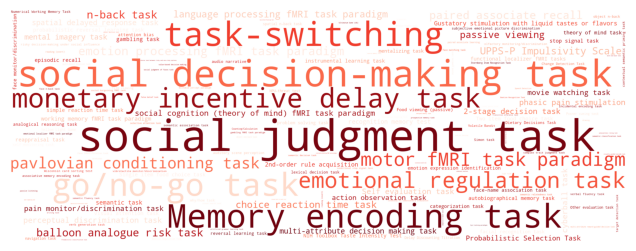

In [33]:
width, height = 8, 3
fig, ax = plt.subplots(figsize=(width, height))

frequencies_dict = dict(statisticmap_colelctions.groupby("cognitive_paradigm_cogatlas_name").size())

wc = WordCloud(
    width=width * DPI,
    height=height * DPI,
    background_color="white",
    random_state=0,
    colormap="Reds",
)
wc.generate_from_frequencies(frequencies=frequencies_dict)
ax.imshow(wc)

ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
for spine in ax.spines.values():
    spine.set_visible(False)


fig.savefig(op.join(fig_dir, "12_cogat_count_pubmed.png"), bbox_inches="tight", dpi=DPI)
plt.show()

### NeuroVault reuse

In [34]:
pubget_metadata_fn = op.join(
    pubget_dir,
    query_neurovault,
    "subset_allArticles_extractedData",
    "metadata.csv",
)
pubget_nv_fn = op.join(
    pubget_dir,
    query_neurovault,
    "subset_allArticles_extractedData",
    "neurovault_collections.csv",
)
pubget_nv_df = pd.read_csv(pubget_nv_fn)
pubget_metadata_df = pd.read_csv(pubget_metadata_fn)

# Convert private_token to collection_id
collection_ids = pubget_nv_df["collection_id"].to_list()
pubget_nv_df["collection_id"] = [
    _convert_collection_id(id_, collections) for id_ in collection_ids
]

# Get PMIDs and PMCIDs from metadata
pubget_nv_df = pd.merge(pubget_nv_df, pubget_metadata_df[["pmcid", "pmid", "doi"]], on="pmcid")
pubget_nv_df = pubget_nv_df.reindex(columns=["pmid", "pmcid", "doi", "collection_id"])
pubget_nv_df = pubget_nv_df.rename(columns={"doi": "secondary_doi"})
pubget_nv_df["pmid"] = pubget_nv_df["pmid"].astype("Int64")
pubget_nv_df = pubget_nv_df.dropna(
    subset=["collection_id"]
)  # Some private collections couldnt be mapped to public ones

# Get collections found by pubget
collections_pmid_nnan_df = collections_pmid_df.dropna(subset=["pmid"])
nv_coll = collections_pmid_nnan_df["collection_id"].to_list()
pubget_nv_coll = pubget_nv_df["collection_id"].to_list()
matching_ids = np.intersect1d(nv_coll, pubget_nv_coll)


In [35]:
nv_reuse_coll = []
for coll_id in matching_ids:
    # PMID per colleciton in collections_pmid_nnan_df is unique, select the first one

    nv_pmid = collections_pmid_nnan_df[collections_pmid_nnan_df["collection_id"] == coll_id]["pmid"].values[0]
    pg_pmids = pubget_nv_df[pubget_nv_df["collection_id"] == coll_id]["pmid"]
    sub_coll = []
    for pmid in pg_pmids:
        if pmid != nv_pmid:
            sub_coll.append(coll_id)
    nv_reuse_coll.extend(list(set(sub_coll)))

nv_reuse_df = pd.DataFrame()
nv_reuse_df["reused"] = ["Reused", "Not Reused"]
nv_reuse_df["count"] = [len(nv_reuse_coll), len(collections_pmid_df) - len(nv_reuse_coll)]

In [36]:
fig = _plot_pie(nv_reuse_df, 'count', 'reused', reversed=True)
fig.write_html(op.join(fig_dir, "13_collections_reused.html"), full_html=True, include_plotlyjs=True)
fig.write_image(op.join(fig_dir, "13_collections_reused.png"), scale=6)
fig.show()

### Distributions of number of images, collections and cognitive atlas tasks

In [37]:
pmid_vs_img = statisticmap_colelctions.groupby('pmid').size().sort_values(ascending=True)
pmid_vs_coll = statisticmap_colelctions.groupby('pmid').apply(_n_colls)[pmid_vs_img.index]
coll_vs_img = statisticmap_colelctions.groupby('collection_id').size().sort_values(ascending=True)
coll_vs_cogat = statisticmap_colelctions.groupby('collection_id').apply(_n_cogats).sort_values(ascending=True)
cogat_vs_img = statisticmap_colelctions.cognitive_paradigm_cogatlas_name.value_counts(dropna=False).sort_values(ascending=True)
cogat_vs_coll = statisticmap_colelctions.groupby('cognitive_paradigm_cogatlas_name').apply(_n_colls)[cogat_vs_img.index]

In [38]:
from plotly.subplots import make_subplots

figures = [
    _plot_hist(cogat_vs_coll, "N Collections"),
    _plot_hist(cogat_vs_img, "N Images"),
]
fig = make_subplots(rows=1, cols=len(figures)) 

for i, figure in enumerate(figures):
    for trace in range(len(figure["data"])):
        fig.append_trace(figure["data"][trace], row=1, col=i+1)

fig["layout"]["xaxis"].update(title="N Collections") # , type="log"
fig["layout"]["xaxis2"].update(title="N Images")
fig["layout"]["yaxis"].update(title="Cognitive Paradigms")
fig["layout"]["yaxis2"].update(showticklabels=False)

fig.update_layout(
    height=30*30,
)

fig.write_html(op.join(fig_dir, "14_cogat_vs_coll-img.html"), full_html=True, include_plotlyjs=True)
fig.show()

In [39]:
from plotly.subplots import make_subplots

figures = [
    _plot_hist(pmid_vs_coll, "N Collections"),
    _plot_hist(pmid_vs_img, "N Images"),
]
fig = make_subplots(rows=1, cols=len(figures)) 

for i, figure in enumerate(figures):
    for trace in range(len(figure["data"])):
        fig.append_trace(figure["data"][trace], row=1, col=i+1)

fig["layout"]["xaxis"].update(title="N Collections") # , type="log"
fig["layout"]["xaxis2"].update(title="N Images")
fig["layout"]["yaxis"].update(title="PMID")
fig["layout"]["yaxis2"].update(showticklabels=False)

fig.update_layout(
    height=30*30,
)

fig.write_html(op.join(fig_dir, "15_pmid_vs_coll-img.html"), full_html=True, include_plotlyjs=True)
fig.show()

###  Distribution of words from abstracts of publications

In [42]:
cogat_dir = op.join(data_dir, "cogat")

vocabulary = _cogat_vocabulary(cogat_dir)

nq_counts_df = _generate_counts(
    pmid_text,
    id_col="pmid",
    vocabulary=vocabulary,
    text_column="abstract",
    tfidf=False,
    max_df=len(pmid_text) - 2,
    min_df=2,
)

		Retaining 1033/1039 studies


In [48]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(6, 5, figsize=(30, 30), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    return fig, axes

In [47]:
from sklearn.decomposition import LatentDirichletAllocation

model = LatentDirichletAllocation(
    n_components=30,
    max_iter=1000,
    learning_method="batch",
    doc_topic_prior=None,
    topic_word_prior=0.001,
)
doc_topic_weights = model.fit_transform(nq_counts_df)

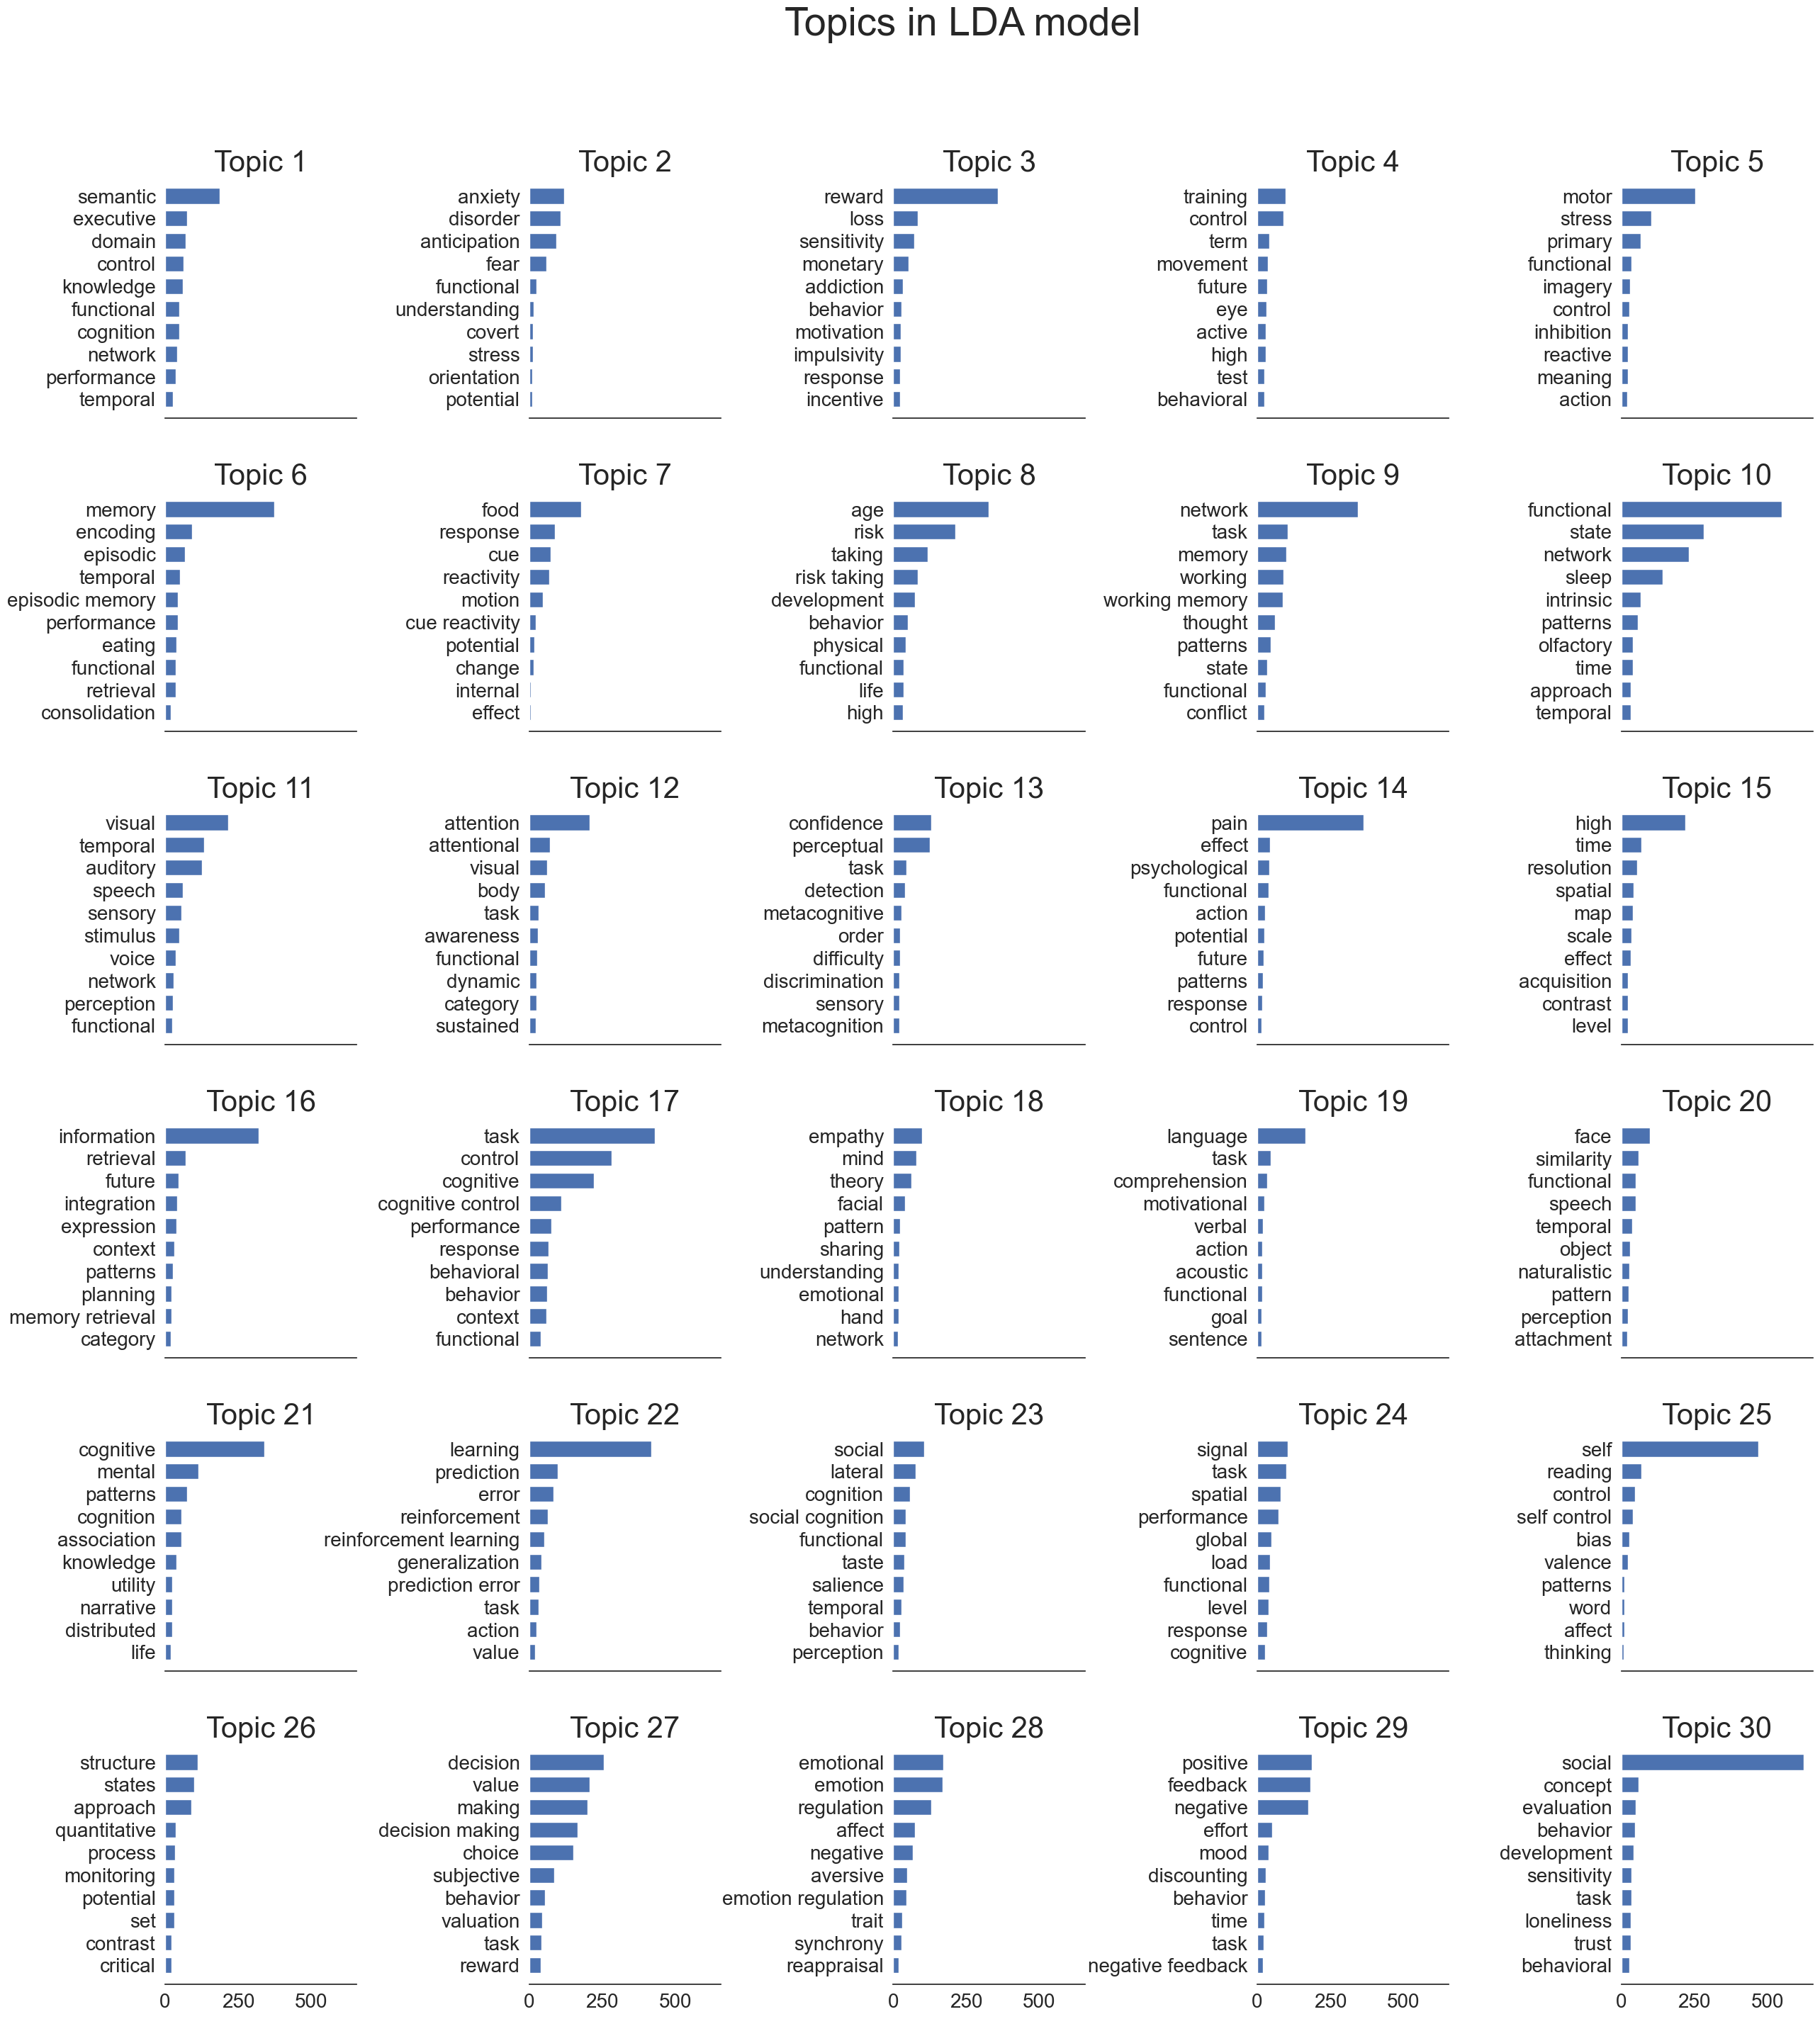

In [49]:
vocabulary = nq_counts_df.columns.to_numpy()
fig, _ = plot_top_words(model, vocabulary, 10, "Topics in LDA model")
fig.savefig(op.join(fig_dir, "16_lda_topics.png"), bbox_inches="tight", dpi=DPI)

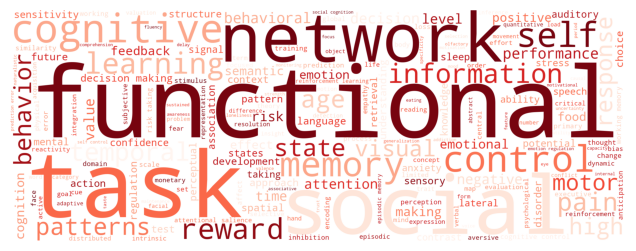

In [52]:
width, height = 8, 3
fig, ax = plt.subplots(figsize=(width, height))

frequencies_dict = dict(nq_counts_df.mean(axis=0))

wc = WordCloud(
    width=width * DPI,
    height=height * DPI,
    background_color="white",
    random_state=0,
    colormap="Reds",
)
wc.generate_from_frequencies(frequencies=frequencies_dict)
ax.imshow(wc)

ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
for spine in ax.spines.values():
    spine.set_visible(False)


fig.savefig(op.join(fig_dir, "17_word_count_pubmed.png"), bbox_inches="tight", dpi=DPI)
plt.show()

### Collections with unique task and multiple images

In [ ]:
coll_with_1cogat = coll_vs_cogat[coll_vs_cogat == 1]
img_per_coll_with_1cogat = coll_vs_img[coll_vs_img.index.isin(coll_with_1cogat.index)]
coll_with_1cogat_mimages = img_per_coll_with_1cogat[img_per_coll_with_1cogat > 1]
coll_with_1cogat_mimages

coll_with_1cogat_mimages_df = pd.DataFrame(coll_with_1cogat_mimages)
coll_with_1cogat_mimages_df = coll_with_1cogat_mimages_df.rename(columns={coll_with_1cogat_mimages_df.columns[0]: "n_images"})
coll_with_1cogat_mimages_df.to_csv(op.join(data_dir, "nv_colls_with_1cogat_mimages.csv"))